The purpose of this notebook is to propose a wine recommendation system based on the textual descriptions of the bottle:

* go to https://www.kaggle.com/zynicide/wine-reviews#winemag-data-130k-v2.csv to ge the data (use the 130k bottles dataset)

# Technical requirements
Mandatory :

    Disk space >= 1Gb 
    RAM >= 4 Gb

    - Python 3.6.x
    - numpy (1.18.0)
    - pandas (0.23.1)
    - matplotlib (2.1.2)
    - seborn (0.8.1)
    - wordcloud (1.6.0)
    - nltk (3.4.5)
    - spacy (2.2.3)
    - sklearn (0.19.1)


Optional:
    - tensorflow-gpu (1.15.0)
    - keras (with tensorflow backend)(2.2.5)
    - tensorflow_hub (0.7.0)

# Challenge description

Author: **Yassine GHOUZAM PhD**

Here we want to build our wine recommendation system. Three types of srecommendation system exists , collaborative filtering systems which are based on user's preferences, content based systems which are based on content description and hybrid system which are based on both content and user's preferences. 
Since our recommendation system will be based only on textual descriptions of the bottle, we will build a content based recommendation system.

Let's first import our packages in order to address this task.

### Imports

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import re
import random
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from sklearn.model_selection import train_test_split
nltk.download('stopwords')

pd.set_option('display.max_colwidth', -1)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yassi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory data analysis

In [2]:
# Column 0 is used to index the dataframe
df = pd.read_csv("winemag-data-130k-v2.csv",index_col=0)

In [3]:
# Display 5 firt rows of the dataframe
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks


In [4]:
print(df.shape)

(129971, 13)


### Columns selection

Our dataset contains around 130k rows and 13 columns. We won't use all of them. Since we want only textual descriptions of the bottle we'll filter out columns we dont need.
Suppose we want to keep only information that appears on the bottle, so we'll keep the country, description, province, title and variety.
We get rid of the designation column since it is redundant with the title column.

In [5]:
df = df.drop(labels=["region_1","region_2","taster_name","taster_twitter_handle"],axis=1)

In [6]:
## Version with all textual description that appears on the bottle
df_text = df.drop(labels=["points","designation","price","winery"],axis=1).copy()

## Version with only the textual description
#df_text = df[["description"]].copy()

In [7]:
df_text.head()

,country,description,province,title,variety
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Sicily & Sardinia,Nicosia 2013 Vulkà Bianco (Etna),White Blend
1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Michigan,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling
4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir


#### Duplicates rows
Let's describe our columns.

In [8]:
describe = df_text.describe()
describe

,country,description,province,title,variety
count,129908,129971,129908,129971,129970
unique,43,119955,425,118840,707
top,US,"Ripe plum, game, truffle, leather and menthol are some of the aromas you'll find on this earthy wine. The tightly wound palate offers dried black cherry, chopped sage, mint and roasted coffee bean alongside raspy tannins that leave a mouth-drying finish.",California,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County),Pinot Noir
freq,54504,3,36247,11,13272


In [9]:
describe = describe.transpose()[["count","unique"]]
describe = describe.reset_index().rename(columns={"index":"feature"})

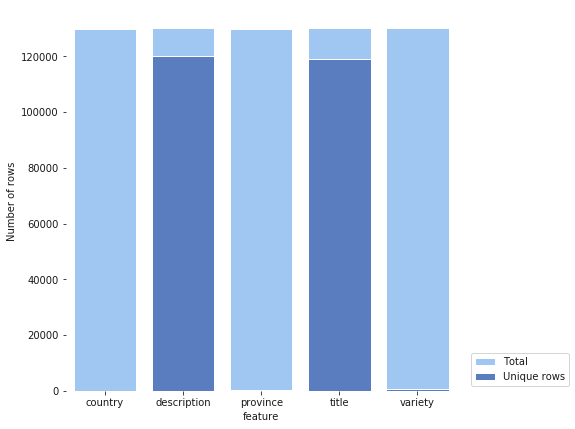

In [10]:
#Barplot of uniques and counting rows
f, ax = plt.subplots(figsize = (7,7))

sns.set_color_codes('pastel')

sns.barplot(x = 'feature', y = 'count', data = describe,
           label = 'Total', color = 'b', edgecolor = 'w')
sns.set_color_codes('muted')

sns.barplot(x = 'feature', y = 'unique', data = describe,
            label = 'Unique rows', color = 'b', edgecolor = 'w').set_ylabel("Number of rows")

ax.legend(ncol = 1, loc = 'lower right',bbox_to_anchor=(1.3, 0))
sns.despine(left = True, bottom = True)

plt.show()

We have 43 differents wine countries , 425 wine provinces and 707 wine varieties. 
We have also duplicates columns since the description columns contains 120K unique texts instead of 130K. So we get rid of duplicates in our dataset.

But before let's explore wine countries.

In [11]:
# Agreggation by counting each non null rows of the description feature and sorting them. 
country_counts= df_text.groupby("country")["description"].count().sort_values(ascending=False)[:10]
labels_counts= country_counts.index

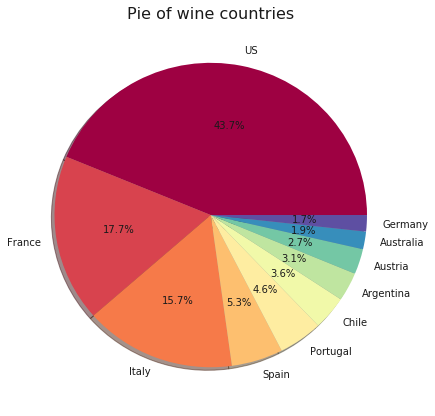

In [12]:
# Set up the figure parameters
plt.figure(1, figsize=(7,7))

# Get the color range for the figure
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]

source_pie = plt.pie(x=country_counts, labels=labels_counts, autopct='%1.1f%%', shadow=True, colors=colors)

# Set up the title
plt.title('Pie of wine countries', fontsize=16)
plt.show()

United States represents the top country in our database with 44% of wines, followed by frane and italy which are closer. 

In [13]:
df_text = df_text.drop_duplicates()

After removing duplicates we have now around 120k rows 

#### NaN values

In [14]:
df_text.isnull().sum()

country        59
description    0 
province       59
title          0 
variety        1 
dtype: int64

We have 59 NaN values concerning country and province features and 1 concerning variety.
We could drop thoses rows or fill the NaN values with "" since these features contain few words contrary to the description column.
I choose the last solution.

In [15]:
df_text = df_text.fillna(value="")

In [16]:
df_text.isnull().sum()

country        0
description    0
province       0
title          0
variety        0
dtype: int64

### Feature concatenation
We will concatenate all text features we have, into one feature.
This will be our main feature for the model. 

In [17]:
text_description = df_text.apply(lambda x : ' '.join([x[col] for col in df_text.columns]) , axis=1).tolist()
# equivalent to text_description = df_text["country"] + ' ' +  df_text["description"] + ' '+ df_text['province'] + ' '+ df_text['title'] + ' ' + df_text['variety']

In [18]:
print(text_description[0])

Italy Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity. Sicily & Sardinia Nicosia 2013 Vulkà Bianco  (Etna) White Blend


In [19]:
## We keep rows from the initial dataset that corresponds to our text dataframe
df = df.loc[df_text.index]

# Text preprocessing

In [20]:
class TextProcessor():
    """
    """
    def __init__(self, normalizer_name = "wordnet",language='english'):
        assert language == 'english', 'Only english is implemented'
        self.language = language
        self.normalizer_name = normalizer_name
        self.normalizer, self.normalize = self._set_normalizer()
        self.stopswords = set(stopwords.words(self.language))
    
    
    def preprocess(self,sentences):
        """
        """
        # loop over all sentences
        res = []
        for sent in sentences:
            clean_sent = self.clean_sentence(sent)
            res.append(self.stops_words_and_normalize(clean_sent))
        return res
    
    def clean_sentence(self,sent):
        """
        """
        # Lowerise the sentence
        res = sent.lower()
        # We remove non-alphanumerical characters (replace by space)
        res = re.sub(r"\W",' ',res)
        # remove single letters
        res = re.sub(r'\s+[a-z]\s+',' ', res)
        # substitute multiple spaces by one space
        res = re.sub(r'\s+',' ', res)
        # Remove begining and ending spaces
        res = res.strip()
        return res
        
    def stops_words_and_normalize(self,sent):
        """
        """
        # Sentence is tokenized and each non stops words is normalized
        return ' '.join([self.normalize(w) for w in nltk.word_tokenize(sent)
                         if w not in self.stopswords])
    
    def _set_normalizer(self):
        """
        """
        if self.normalizer_name == "wordnet":
            normalizer =  WordNetLemmatizer()
            normalize = normalizer.lemmatize
        elif self.normalizer_name == "porter":
            normalizer =  PorterStemmer()
            normalize = normalizer.stem
        else:
            raise NotImplementedError("'{}' normalizer is not implemented, please \
                                       use lemmatizer or porter".format(self.normalizer_name))
        
        return normalizer, normalize

The TextProcessor class contains methods for cleaning and normalize sentences.

##### Sentences cleaning
    - The method .clean_sentence() clean the sentence by changing it to lower-case form and removing all non-alphanumerical characters, single letters and multiples spaces.
    
##### Word normalization
    - I choose to normalize words since we want to extract the general meaning of each word individually in textual descriptions (i.e fruits, fruited -> fruit). We are not doing seq2seq tasks that requires the understanding of the sentence grammar such as translation, text summarization and so on.
    The method ._set_normalizer() sets and initiliaze the normalizer method and the .stops_words_and_normalize() normalizes words of each sentence. I'hve implemented two methods from the nltk library, a lemmatisation method which is based on the WordNet model and a stemmating method based on the Porter method.
    I prefer lemmatisation but this method is more computionnaly expensive than Porter stemming. Since we have 130k textual descriptions we rather prefer using Porter stemming.
    
##### Stops words and tokenization
    - Stops words are very common words in a sentence (i.e the , in , is , an , it ...) they have'nt any meaning in our textual descriptions. Moreover they are very frequent words and are meaningless. So used to get rid of these words. 
    The method .stops_words_and_normalize() first tokenize the sentence and removes the english stops words and normalize each non stops words of the sentences.

In [21]:
textprocessor = TextProcessor(normalizer_name="porter")

### text pre-processing

In [22]:
%%time
# May take around 2 min
processed_text = textprocessor.preprocess(text_description)

Wall time: 2min 3s


### Wines Wordclouds

In [23]:
def select_country_wines_text(df, all_text, country):
    # We select the country based on the dataframe infos
    bools = (df["country"]==country)
    
    # we select the text feature based on the idx selected
    text_country = [all_text[i] for i, b in enumerate(bools) if b]
    
    return text_country

In [24]:
# Let's get french wines
fr_texts = select_country_wines_text(df = df, all_text=processed_text,country="France")

# Let's get US wines
us_texts = select_country_wines_text(df = df, all_text=processed_text,country="US")

# Let's get Italian wines
it_texts = select_country_wines_text(df = df, all_text=processed_text,country="Italy")

In [25]:
def generate_wordcloud(texts, country):
    # concat all words
    concat_texts = " ".join([text for text in texts])
    
    # Get the wordcloud object
    wordcloud = WordCloud(background_color="white",
                      max_words=len(concat_texts),max_font_size=40,
                      relative_scaling=.5,
                    mask=np.array(Image.open("img/{}_mask.jpg".format(country)))).generate(concat_texts)
    return wordcloud

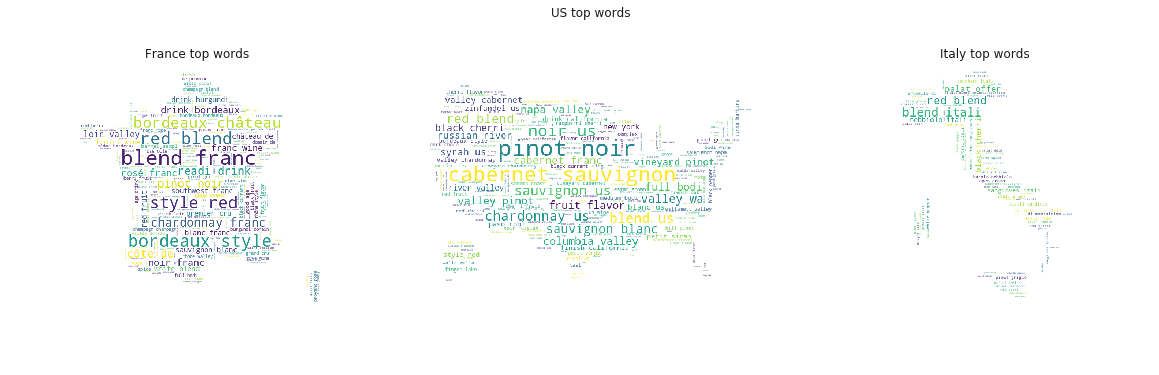

In [26]:
fig,axs =  plt.subplots(ncols=3,figsize=(20,10))

fr_wc = generate_wordcloud(texts = fr_texts,country="fr")
axs[0].imshow(fr_wc)
axs[0].set_title("France top words")
axs[0].axis("off")

us_wc = generate_wordcloud(texts = us_texts,country="us")
axs[1].imshow(us_wc)
axs[1].set_title("US top words")
axs[1].axis("off")

it_wc = generate_wordcloud(texts = it_texts,country="it")
axs[2].imshow(it_wc)
axs[2].set_title("Italy top words")
axs[2].axis("off")

plt.show()

# Text feature extraction

After cleaning and normalizing each description. We will now process to the text feature extraction by converting our sentences into a list of vectors of values (matrix). We will call this process the text vectorization.

We will implement two :
    - The bag of words vectorizer
    - The TfIDF vectorizer

In [27]:
class Vectorizer():
    """
    """
    def __init__(self,method="tfidf", **kwargs):
        self.method = method
        self.kwargs = kwargs
        self.vectorizer = self._set_vectorizer()
    
    def fit_transform(self,X):
        """
        """
        self.vect_mtx = self.vectorizer.fit_transform(X)
    
    def vectorize(self,sentences):
        """
        """
        return self.vectorizer.transform(sentences)
    
    def _set_vectorizer(self):
        """
        """
        if self.method == "tfidf":
            vectorizer =  TfidfVectorizer(**self.kwargs)
        elif self.method == "bow":
            vectorizer =  CountVectorizer(**self.kwargs)
        else:
            raise NotImplementedError("'{}' vectorizer is not implemented, please use 'bow'\
            for Countvectorizer or 'tfidf' for TfidfVectorizer".format(self.method))
        
        return vectorizer

The class Vectorizer contains the methods that vectorize the text.

    -The method ._set_vectorizer() initialize the vectorizer (tfidf or bow with their arguments). I used the sklearn library implementation of TFIDF and BOW vectorizer.

    -The method .fit_transform() fits the words of a list of sentences and transforms it into a matrix.

    -The method .vectorize() transforms a list of sentences into a matrix using the fitted text information.

I choose to filter out all words that appears only in one document (min_df = 2) and in more than 80% of the documents (max_df = 0.8).

Using bi or trigrams (ngram_range=(1,3)) would give better results since we take into account some contextual words but it may lead to a very huge number of differents words combination.

### Bag Of words

A bag of words is a representation of text that describes the occurrence of words within a document.

In [28]:
# BOW Vectorizer initialization
cvec = Vectorizer(method="bow",min_df = 2, max_df=0.8) #, ngram_range=(1,3))

# BOW vectorizer fitting
cvec.fit_transform(processed_text)

### TF-IDF

TF-IDF is a method that counts the occurrence of each words in a document and weight the importance of each words, in order to calculate a score for that document.

It is composed of two terms :
    - Term Frequency
    - Inverse Document Frequency

The term frequency is the frequency of the word in the current document to the total number of words in the document. It signifies the occurrence of the word in a document and gives higher weight when the frequency is more so it is divided by document length to normalize.


The inverse Document Frequency is the total number of documents to the frequency occurrence of documents containing the word. It signifies the rarity of the word as the word occurring the document is less the IDF increases. It helps in giving a higher score to rare terms in the documents.

In [29]:
# TFIDF vectorizer initialization
tfidfvec = Vectorizer(method="tfidf", min_df = 2, max_df=0.8) #, ngram_range=(1,3))

# TfIDF vectorizer fitting
tfidfvec.fit_transform(processed_text)

# Recommender system

### Recommenders System using Word embeddings with Spacy (may take around 5 minutes to compute)

Here we used Spacy similarity function between documents.
This function compute a cosine similarity based on the embedded documents.
 - First the document or the sentence is tokenized (i.e split into separate words).
 - Each word is embedded using the GloVe vectors (GloVe is Matrix Factorization of log counts with respect to weigthed squared loss) (by default 300 embedding dimensions)
 - The embedded document/sentence is computed by averaging each word vectors of the document/sentence.
 - A cosinue similarity is then computed between the two vectors

In [30]:
# Spacy has to be installed and the english medium model also 
# python -m spacy download en_core_web_md
import spacy
nlp = spacy.load('en_core_web_md',disable=["parser","ner"])

class SpacySimilarity():
    """
    """
    def __init__(self):
        pass
        
    def compute_spacy_database(self, sentences):
        """
        """
        # Each processed text have to be converted into spacy objects
        self.docs = [nlp('u"'+sent+'"') for sent in sentences]
        
    def spacy_similarity(self, query):
        """
        """
        # Convert the query into Spacy object
        query_spacy = nlp('u"'+query+'"')
        # Compute similarity between the query and all the database
        results = [query_spacy.similarity(sent) for sent in self.docs]
        return np.array(results) 

In [31]:
%%time
# initiliaze SpacySimilarity object
spacysim = SpacySimilarity()
# transform each documents to spacy objects (take around 5 minutes to compute)
spacysim.compute_spacy_database(processed_text)

Wall time: 6min 24s


### Using TFIDF/BOW and cosine similarity

![cosine](img/cosine-similarity.png)

Cosine similarity is a metric used to determine how similar the documents are irrespective of their size.

This metric is based on the angle between two vectors projected in a multi-dimensional space. In our context, the two vectors containing the word counts or word embedding of two documents.

The cosine similarity is advantageous because even if the two compared documents are very different regarding their lenght , the cosine similarity still high.

We have done text feature extractions using some description of bottle wine. 
We have now each wine bottle described using Tf-IDF or Bag of words matrices.
We use cosine similarity to compute the distance between two bottle's descriptions

In [32]:
class Recommender():
    """
    """
    def __init__(self, database, vectorizer=None, use_spacy=False):
        self.database = database
        self.use_spacy = use_spacy
        
        if not self.use_spacy:
            assert vectorizer is not None, '"use_spacy = False" requires vectorizer not None'
            self.vectorizer = vectorizer
            assert self.vectorizer.vect_mtx.shape[0] == len(database), 'vectorizer and database lengths are different.\
                                                                        Vectorizer must be fit on database'
        else :
            assert len(spacysim.docs) == len(database), 'spacysim.compute_spacy_database()\
                                                         must be computed on database'
            
    def recommend(self, query, N = 10):
        """
        """
        # Process the query sentence
        processed_query = textprocessor.preprocess([query])
        
        if self.use_spacy:
            # Compute similarity between query and database using spacy (word2vec embedding)
            results = spacysim.spacy_similarity(query=processed_query[0])
        
        else :
            # Transform the query with the Vectorizer
            query_mtx = self.vectorizer.vectorize(processed_query)
            
            # Compute cosine similarity between the query and the database
            results = cosine_similarity(query_mtx, self.vectorizer.vect_mtx).reshape(-1)
            
        # Results are reverse sorted
        idx = results.argsort()[::-1][:N]
        
        print("Query : {}".format(query))
        df_reco = self.database.iloc[idx].copy()
        df_reco["score"] = results[idx]
    
        return df_reco.reset_index(drop=False)

#### Recommendation using K-Nearest Neighbors 

Let's use a simple algorithm perfectly adapted for recommendation systems, K-Nearest Neighbors (KNN).

KNN is a simple algorithm that stores all input data and classifies new input based on a similarity measure.

By default the metric used in the KNN is a generalization form of the euclidian distance (Minowski distance). The p parameter controls the form of the minowski metric (e.g p=1 and p=2 corresponds to the Manhatthan and euclidian distance respectively). I have set up the p parameter to 2 which correpond to an euclidian distance form of the minowski metric.

In [33]:
from sklearn.neighbors import NearestNeighbors

In [34]:
class KNNrecommender():
    """
    """
    def __init__(self, vectorizer, **kwargs):
        self.kwargs = kwargs
        self.vectorizer = vectorizer
        self.KNN = NearestNeighbors(**kwargs)
        self.KNNfit()
        
    def KNNfit(self):
        """
        """
        self.KNN.fit(self.vectorizer.vect_mtx)
    
    def KNNrecommend(self,query, database, N=10):
        """
        """
        assert len(database) == self.vectorizer.vect_mtx.shape[0], 'vectorizer and database lengths\
                                                                    are different. Vectorizer must be fit on database'
        assert N <= self.KNN.n_neighbors , 'N must be <= to KNN.n_neighbors'
        processed_query = textprocessor.preprocess([query])

        query_mtx = self.vectorizer.vectorize(processed_query)
        distances, indices = self.KNN.kneighbors(query_mtx, return_distance=True)

        print('Query : {}'.format(query))
        df_reco = database.iloc[indices[0][:N]].copy()
        df_reco['distance'] = distances[0][:N]

        return df_reco.reset_index(drop=False)

## Results 

It's hard to compare recommendation system when you dont have any rating from users. So we will do it mannually. Indeed the real true metric of recommendation systems is the A/B testing. For instance, we compare our recommendation system to a random based system and get the evaluation from the users. the metrics you use should be adjusted to the specific use case and measure what’s relevant to the business. For example you could measure the interaction (click rate...) and business impact with and without this recommendation system.

#### Recommendation using KNN based on BOW matrices

In [35]:
# Example of recommendation using KNN based on BOW
knnrecommender = KNNrecommender(vectorizer=cvec, n_neighbors=10, p=2)

query = "California orange wine"
knnrecommender.KNNrecommend(query=query, database=df, N=10)

Query : California orange wine


,index,country,description,designation,points,price,province,title,variety,winery,distance
0,94597,US,"This has creamy flavors of vanilla, honey, lime and orange.",NaN,82,10.0,California,Bogle 2011 Chardonnay (California),Chardonnay,Bogle,3.741657
1,121851,US,"You can technically call this a table wine, but it's really sweet, with orange and honey flavors.",NaN,84,10.0,California,Discoveries 2010 Moscato (California),Moscato,Discoveries,3.872983
2,23920,US,"A simple wine, it tastes overoaked and thin in oranges and apricots, with brisk acidity.",NaN,82,22.0,California,Jacella 2011 Chardonnay (Carneros),Chardonnay,Jacella,3.872983
3,83840,US,"A soft, simple wine, with cherry cough medicine flavors.",NaN,81,10.0,California,Discoveries 2009 Merlot (California),Merlot,Discoveries,3.872983
4,21841,US,"Watery and sweet, with apricot and orange jam flavors.",NaN,80,11.0,California,Kitchen Sink NV Chardonnay (California),Chardonnay,Kitchen Sink,3.872983
5,123451,US,"As sweet as a dessert wine, with simple pineapple jam flavors.",NaN,82,9.0,California,Surf Point 2010 Chardonnay (California),Chardonnay,Surf Point,4.000000
6,113382,US,"Seemingly sweet and simple, this has orange and butterscotch candy flavors.",NaN,82,10.0,California,Lost Angel 2010 Chardonnay (California),Chardonnay,Lost Angel,4.000000
7,108278,US,"Sweet and simple, with jammy raspberry and bubblegum flavors.",NaN,82,7.0,California,Barefoot NV Shiraz (California),Shiraz,Barefoot,4.000000
8,30141,US,"This is a rewarding wine, with flavors of orange and pineapple. It finishes with a honeyed minerality.",NaN,87,17.0,California,Wild Horse 2010 Chardonnay (Central Coast),Chardonnay,Wild Horse,4.000000
9,48356,US,"So sweet, it's basically a dessert wine, with simple, sugary flavors of oranges, apricots and vanilla.",NaN,82,12.0,California,Mirassou 2010 Riesling (California),Riesling,Mirassou,4.000000


#### Recommendation using KNN based on TFIDF matrices

In [36]:
# Example of recommendation using KNN based on tfidf
knnrecommender = KNNrecommender(vectorizer=tfidfvec,n_neighbors=10)

query = "California orange wine"
knnrecommender.KNNrecommend(query=query, database=df, N=10)

Query : California orange wine


,index,country,description,designation,points,price,province,title,variety,winery,distance
0,89663,US,"This is an interesting rosé, with a light burnt-orange hue and an orange theme throughout. It's evident from wild, sweet orange on the nose to clementine, orange blossom and orange candy flavors on the palate. There are other aromas such as cherry cough drops and raspberries, while the palate is fruit forward, with flabby acidity.",White Norton,84,22.0,Virginia,New Kent 2014 White Norton Rosé (Virginia),Rosé,New Kent,1.069773
1,17437,US,"With residual sugar of 15.2%, this is a very sweet wine, but crisp acidity gives it complete balance. The flavors are direct and appealing and, as the variety suggests, powerful in tangerines and honeyed oranges.",Late Harvest,87,15.0,California,Fiore d'Arancio NV Late Harvest Orange Muscat (California),Orange Muscat,Fiore d'Arancio,1.086300
2,67693,US,"With a notable orange tinge, the aromas offer notes of flowers and orange peel, seeming to show a touch of oxygen exposure. It drinks off dry, with abundant orange-rind and smoke flavors.",Lé Orange Vintner's Select,85,20.0,Washington,Almquist 2014 Lé Orange Vintner's Select Pinot Gris (Washington),Pinot Gris,Almquist,1.091175
3,75993,US,"This is a pretty wine in terms of floral aromatics, resplendent shocks of orange blossom and orange peel inviting in their exotic freshness. Lime and orange follow on the palate, which is bristling in acidity, the finish light and bright.",Dijon Clones,89,34.0,California,Pine Ridge 2013 Dijon Clones Chardonnay (Carneros-Napa Valley),Chardonnay,Pine Ridge,1.108733
4,87233,US,"An orange shade of pink, this wine leans toward dried lemon and orange peels with a slight bit of bubble gum and pomegranate on the nose. The flavors are more concentrated than bright, with iodine and dried fruit character, more reminiscent of an orange wine than a pink one.",Rosé of,85,20.0,California,Standing Sun 2013 Rosé of Syrah (Santa Barbara County),Syrah,Standing Sun,1.110250
5,114382,US,"Beautiful rose petal, orange blossom and honey flavors practically leap out of the glass as this sweet, lightly sparkling and nicely concentrated wine works its charms. It has good acidity to balance all the sugary sweetness, and a low alcohol strength.",NaN,90,14.0,California,Electra 2015 Orange Muscat (California),Orange Muscat,Electra,1.110307
6,43699,US,"Absolutely delicious, an addictive dessert wine. Brisk in acidity and clean in the mouth, it offers fabulously sweet flavors of oranges, vanilla, honey and buttered toast. Drink it with cheesecake and go to heaven.",Essensia,93,21.0,California,Quady 2010 Essensia Orange Muscat (California),Orange Muscat,Quady,1.117500
7,92955,US,"Some might characterize this as a dessert wine, but it's actually quite dry, with brisk acidity accompanying orange, peach, honey and vanilla flavors. No oak was involved, leaving the wine fresh and vibrant.",NaN,87,17.0,California,Santa Barbara Winery 2012 Orange Muscat (Santa Barbara County),Orange Muscat,Santa Barbara Winery,1.118254
8,92520,US,"This sweet and flavorful wine has an orange-amber color and one of the most floral, perfumed aromas of any wine from anywhere. It smells like a giant bouquet of roses, jasmine and honeysuckle and tastes similarly, buoyed by apricot and peach flavors and a lively streak in the texture.",Deviation,93,25.0,California,Quady NV Deviation Orange Muscat (California),Orange Muscat,Quady,1.118517
9,96959,US,"An extremely pungent florality hits the nose on this sweeter bottling, with orange blossoms, strong white flowers and a quinine character. The palate is brightly sweet but far from overly done, with perfumed night jasmine mixing into more orange-blossom elements. Perhaps this wine is an acquired taste, but it's clean and crisp.",Margaret's Vineyard,87,16.0,California,Robert Hall 2014 Margaret's Vineyard Orange Muscat (Paso Robles),Orange Muscat,Robert Hall,1.122662


#### Recommendation based on cosine sim of BOW matrices

In [37]:
# Example of recommendation using BOW
#Randomly choose a query description 
query = df["description"].iloc[random.randint(0,df.shape[0])]

recommender = Recommender(database = df, vectorizer = cvec)
recommender.recommend(query = query , N=5)

Query : A lifted lemon-scented nose of peach gives and impression of ease and lightness. The palate, however, lays on generous sweetness to focus on ripe juicy peach notes. There is a huge concentration of flavor and richness, countered by that lemony freshness. This is a big but gentle wine that leaves your mind ringing with peach and lemon and a touch of honeysuckle spice. The medium-sweet finish is long and balanced. Drink 2017–2017.


,index,country,description,designation,points,price,province,title,variety,winery,score
0,22355,France,"A lifted lemon-scented nose of peach gives and impression of ease and lightness. The palate, however, lays on generous sweetness to focus on ripe juicy peach notes. There is a huge concentration of flavor and richness, countered by that lemony freshness. This is a big but gentle wine that leaves your mind ringing with peach and lemon and a touch of honeysuckle spice. The medium-sweet finish is long and balanced. Drink 2017–2017.",Ehrhart Hengst Grand Cru,94,32.0,Alsace,Domaine Saint-Rémy 2015 Ehrhart Hengst Grand Cru Gewurztraminer (Alsace),Gewürztraminer,Domaine Saint-Rémy,0.889757
1,22356,France,"Peach and honeysuckle already have a notion of honeyed sweetness and ripeness on the nose. The palate boosts both fruit and floral notion to the top, where honeysuckle and rose petal notes meeting with peach on the medium-sweet palate. This is full on, joyous, juicy and rich with expressive, exuberant flavor. An underlying concentration almost feeds this with a fiery dynamic force. The finish is medium sweet but comes with a wonderfully redeeming pure lemon streak. This is ready now but will get even better with age. Drink 2017–2037.",Clos Saint-Théobald Rangen Grand Cru,94,49.0,Alsace,Domaine Schoffit 2015 Clos Saint-Théobald Rangen Grand Cru Gewurztraminer (Alsace),Gewürztraminer,Domaine Schoffit,0.442767
2,100191,France,"There is an earthy touch to the almost overripe peach notes on the nose. The palate adds both sweetness and a subtle welcome hint of phenolic bitterness to the peachy fruit. Bright lemon freshness cuts through the medium-sweet palate to provide a fresh, almost lip-smacking finish. This wine is full of ripe expressive fruit flavors, giving equal billing to lemon and peach.",Mambourg Grand Cru,92,40.0,Alsace,Jean-Marc Bernhard 2015 Mambourg Grand Cru Gewurztraminer (Alsace),Gewürztraminer,Jean-Marc Bernhard,0.430528
3,15658,France,"A very lifted touch of fir honey hits the nose first before ripe peach with the merest touch of vanilla follow. The palate is incisive and concentrated. Alcoholic heat fires up the mellow, rich and rounded palate that brims with peachy fruit and flavor while zesty lemon oil hints illuminate and brighten the richness. This seems to have only just started on its trajectory. It is ready to drink but it will evolve much further, becoming ever more itself. The finish is just off dry and very long with lemon zest and peach. Drink 2017–2037.",Grossi Laüe,94,75.0,Alsace,Hugel 2011 Grossi Laüe Gewurztraminer (Alsace),Gewürztraminer,Hugel,0.412948
4,16733,France,"A touch of narcissus precedes the full-fruited notes of peach on the nose. The palate has the same generous peach but also a slightly bitter tangy edge that gives structure to the rich wine. This is intense, rich and medium sweet, with a lasting rich finish.",Cuvée Mégane,90,30.0,Alsace,Domaine G. Metz 2014 Cuvée Mégane Gewurztraminer (Alsace),Gewürztraminer,Domaine G. Metz,0.390583


#### Recommendation based on cosine sim of TFIDF matrices

In [38]:
# Example of recommendation using TfIDF
query = "Porto Portugal caramel"
#query = df["description"].iloc[random.randint(0,df.shape[0])]

recommender = Recommender(database = df, vectorizer = tfidfvec)
recommender.recommend(query = query , N=5)

Query : Porto Portugal caramel


,index,country,description,designation,points,price,province,title,variety,winery,score
0,96838,Portugal,"Light in color and soft, this is a caramel-flavored wine that is all fruit. It is open and generous, with just a light tang of acidity at the end.",Réccua Reserva Especial,85,14.0,Port,Porto Reccua Vinhos NV Réccua Reserva Especial (Port),Port,Porto Reccua Vinhos,0.384806
1,54226,Portugal,"Get past the meaty aromas and the wine is smooth, caramel and spice flavored. The wood flavors are prominent suggesting the wine has been aged well. At the end, berry fruits and acidity come through.",Porto Tawny Reserve,86,14.0,Port,Borges NV Porto Tawny Reserve (Port),Port,Borges,0.377161
2,33442,Greece,"Butterscotch, honey and spice aromas lead this white from Porto Carras. The wine has a slightly heavy feel with vanilla and spice overtones leasing. Overall though, a pretty wine with a serious character.",NaN,88,25.0,Sithonia,Porto Carras 2014 Malagousia (Sithonia),Malagousia,Porto Carras,0.323541
3,62570,Portugal,"Medicinal, herbal wine, with attractive white fruit aromas. The palate is rich and soft, with fresh honey and sweet fruits. Definitely sweet, it is still balanced with the fruits and the spirit underlay.",Porto Branco,88,NaN,Port,Ferreira NV Porto Branco (Port),Port,Ferreira,0.298943
4,51901,Portugal,"This is a smooth, toffee and caramel-flavored wine. It has a comfortable maturity, with acidity coming from hints of fruitiness, and sweet sultanas acting as a foil. Like any aged tawny, this magnificent wine is ready to drink.",Porto Tawny 40 Years Old,93,NaN,Port,Senhora do Convento NV Porto Tawny 40 Years Old (Port),Port,Senhora do Convento,0.297913


#### Recommendation based on cosine sim of Word embeddings using spacy

In [39]:
# Example of recommendation with spacy 
query = "Bordeaux France red wine fruit"
#query = df["description"].iloc[random.randint(0,df.shape[0])]

recommender = Recommender(database = df, use_spacy=True)
recommender.recommend(query = query , N=5)

Query : Bordeaux France red wine fruit


,index,country,description,designation,points,price,province,title,variety,winery,score
0,30074,France,"Fresh and fruity with creamy green and white fruits, this is a soft, ready to drink Chardonnay. Attractively fruity, the acidity finely cuts through the wine.",Bourricot,85,11.0,France Other,L. Tramier & Fils 2011 Bourricot Chardonnay (Vin de France),Chardonnay,L. Tramier & Fils,0.928673
1,69912,France,"This wine is way too light, too fresh and without much in the way of structure. Green fruit and acidity are dominant with just hints of red fruits.",Demoiselle Bleue,83,15.0,Loire Valley,Alliance Loire 2014 Demoiselle Bleue Cabernet Franc (Bourgueil),Cabernet Franc,Alliance Loire,0.925676
2,105028,France,"Perfumed wine, from a blend of Tannat and Cabernet Franc. Here is a powerful expression of intense terroir. Very concentrated and dense, with the tannins just beginning to soften, the wine is packed with black ripe fruits, solid and chunky.",NaN,92,14.0,Southwest France,Château Peyros 2006 Tannat-Cabernet Franc (Madiran),Tannat-Cabernet Franc,Château Peyros,0.920852
3,20612,France,"This oddly named Cabernet Sauvignon is fine. It has light tannins, a juicy, stalky character, upfront black currant fruit and balanced acidity. Drink now.",Romantic,87,10.0,France Other,L. Tramier & Fils 2015 Romantic Cabernet Sauvignon (Vin de France),Cabernet Sauvignon,L. Tramier & Fils,0.919978
4,59640,France,"A fruity blend of Tannat, Syrah and Cabernet Franc that has berry fruits, a stalky texture and touches of wood spice. It's an easy, juicy wine, made fresh and ripe to be drunk now.",Aramis,85,10.0,France Other,Château d'Aydie 2013 Aramis Red (Vin de France),Red Blend,Château d'Aydie,0.915704


# Improvements

Even if these models seem to work pretty well, there is still room for improvements.
For feature extraction we used here simple models such as Bag of words (BOW) and Tf-IDF.
But these models have drawbacks such as the lack of word contextual understanding.

    - In order to take into account the context of words, we could tune our BOW and TF-IDF vectorizer using Bigrams and Trigrams (use ngram_range=(1,3) parameter). This will produce a lot of different combinaison of words so pay attention to the ram consumption.
    
    - Hybrid recommendation system models are very powerfull. It would be nice to take into account both textual informations and user's preferences using the columns points and tester_name and build an hybrid recommendation system. 
    
    - Recommendation quality results relies also on the query quality. We know that in real life there is frequently misspelling in query searchs. It would be secure to correct spelling mistakes in the query with a simple and fast algorithm based on levenshtein distance or word embeddings distances for instance (Chardonay -> Chardonnay).
    
    - Since descriptions contains some words in other languages, we could test multilingual pre-trained word embedding models using multilanguage Google's Word2Vec (CBOW or Skip gram) models ,GloVe (as we did with Spacy but for english version)or Facebook's FastText words embeddings vectors.
    
    - A better improvement, i think, would be to train our own words embeddings vectors using words founds in these corpora. This will allow us to get a more relevant meaning of each word vector due to their context (i.e words 'dominant','acidity' and 'spicy' would be closer than using words embeddings vectors trained on a general corpora). We can do this using Continuous Bag of word or Skip Grams models. Gensim has a great API to dot this. We can also build and train them from scratch using Keras and tensorflow if we want more control. 
    
    - Clustering could also improve the quality of the recommendation by incorporating variety and diversity, if we recommand K similar, but representative, types of wines based on the clustering results. Algorithms like K-means or DBSCAN are perfect for such tasks. 
    
    - We can treat some feature separately since they are very discriminative. Such as the wine color. 
    
    - Proper nouns should remains attached example ("Petit Bourgeois" -> 'Petit_Bourgeois', since Petit and Bourgeois separately does not make sense. Doing Ngrams (bigrams for instance) allows us to take this into account.
    
    - Instead of averaging words's word embedding vectors in a sentence (like Spacy does) we could have used semantic similarity using Doc2Vec models (ParagraphVector Distrubuted Memory or ParagraphVector Distrubuted Bag of Words) which outperform simple word2vec averaging models. Gensim package has a good API to perform such tasks or build it from scratch using keras. Requires time, space memory and GPU bandwith for training. 
    
    - Usage of sentence embedding encoders based on transformers networks. Since 2018 it's the transformers revolution in NLP. These models use attention mechanism which improve largely the understanding of the sementic of a sentence. Google has developed BERT model and Universal Sentence Encoder (USE), both of them are based on transformers networks. We could have used USE to get sentences embedding vectors of our query text and generate wine recommendations based on the semantic similarity between wine descriptions and the query. Same as with BERT embeddings vectors.
    
    - A last but not least improvement could be to use Text summarization models such as TextRank (extractive) , BERT or Pointer Generator (best and abstractive) in order to do feature engineering. These models would allow us to generate a small summary of each description, that can fed our BOW/TfIFD models. I would recommand abstractive summaries technique since they'll add new unseen words. I consider this improvement as experimental it's clearly not a must have.
    

# Bonus recommender using Universal Sentence Encoder
**(Run with Tensorflow-gpu >= 1.15.0), requires a huge amount of RAM memory**

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"

In [ ]:
def embed_init():
    with tf.Graph().as_default():
        text_input = tf.compat.v1.placeholder(dtype = tf.string, shape=[None])
        embed = hub.Module(module_url)
        em_txt = embed(text_input)
        session = tf.compat.v1.train.MonitoredSession()
    return lambda x:session.run(em_txt, feed_dict={text_input:list(x)})

In [ ]:
embed_fn = embed_init()

# Use a small amount of the data to reduce memory usage
N_df = 1000
embed_df = embed_fn(processed_text[:N_df])

In [ ]:
def USE_content_recommender(query, database, embedding_df = embed_df, N=10):
    """
    """
    processed_sent = textprocessor.preprocess([query])
    embedding = embed_fn(processed_sent)
    similarity_score = np.dot(embedding, embedding_df.T)
    
    idx = similarity_score.argsort()[0][::-1][:N]
    df_reco = database.iloc[idx].copy()
    
    df_reco["score"] = np.sort(similarity_score)[0][::-1][:N]
    
    return df_reco

In [ ]:
# Example of a recommendation using USE
query = "Australian vanilla Chardonnay"

USE_content_recommender(query = querys, database = df , N= 10)